In [ ]:
# Autoreload packages in case they change.
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import btk
import btk.plot_utils
import ipywidgets as widgets
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
from IPython.display import clear_output, display

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'
from btk import DEFAULT_SEED
seed = DEFAULT_SEED

# 0. Testing for red component in galaxies with `DefaultSampling`

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

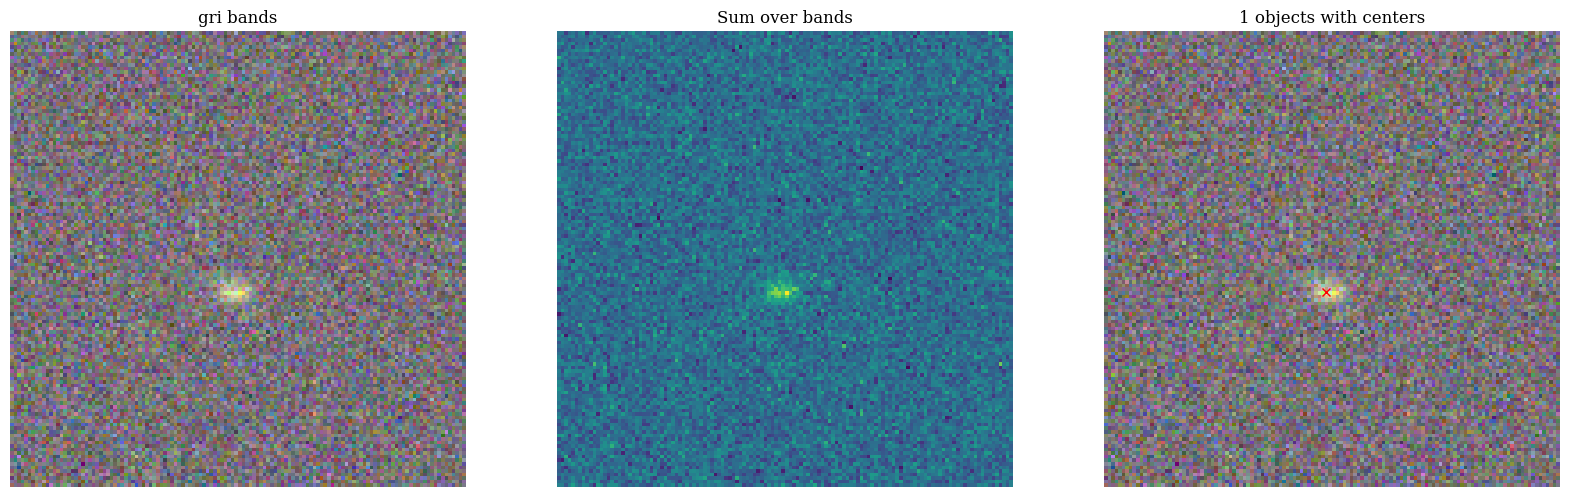

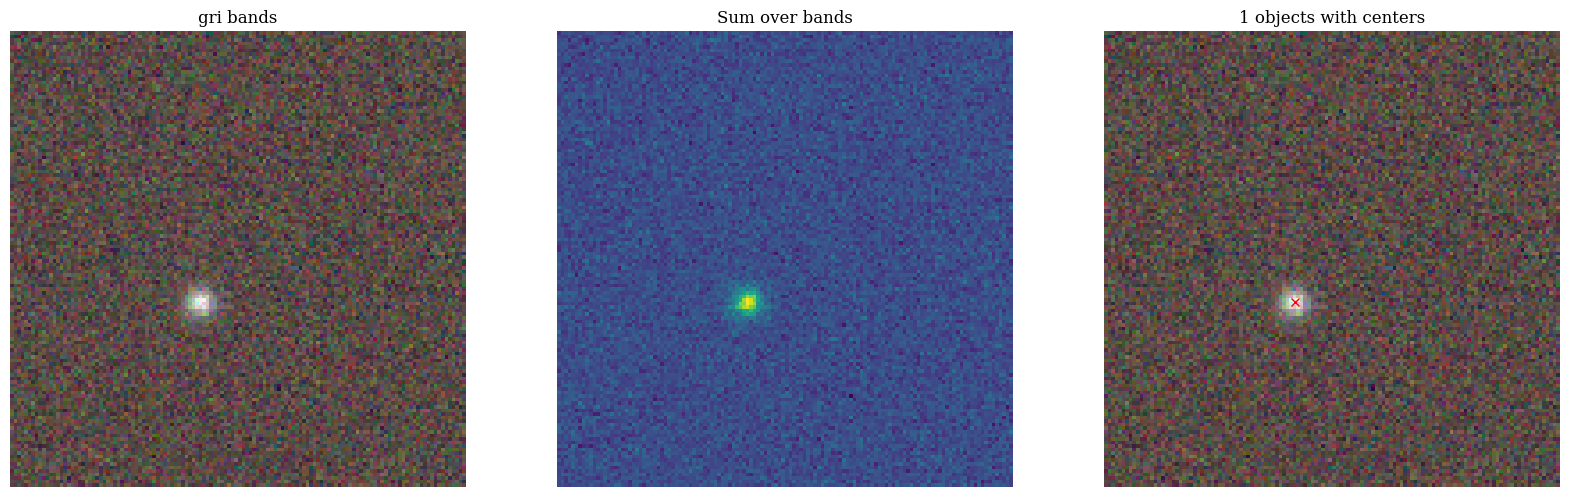

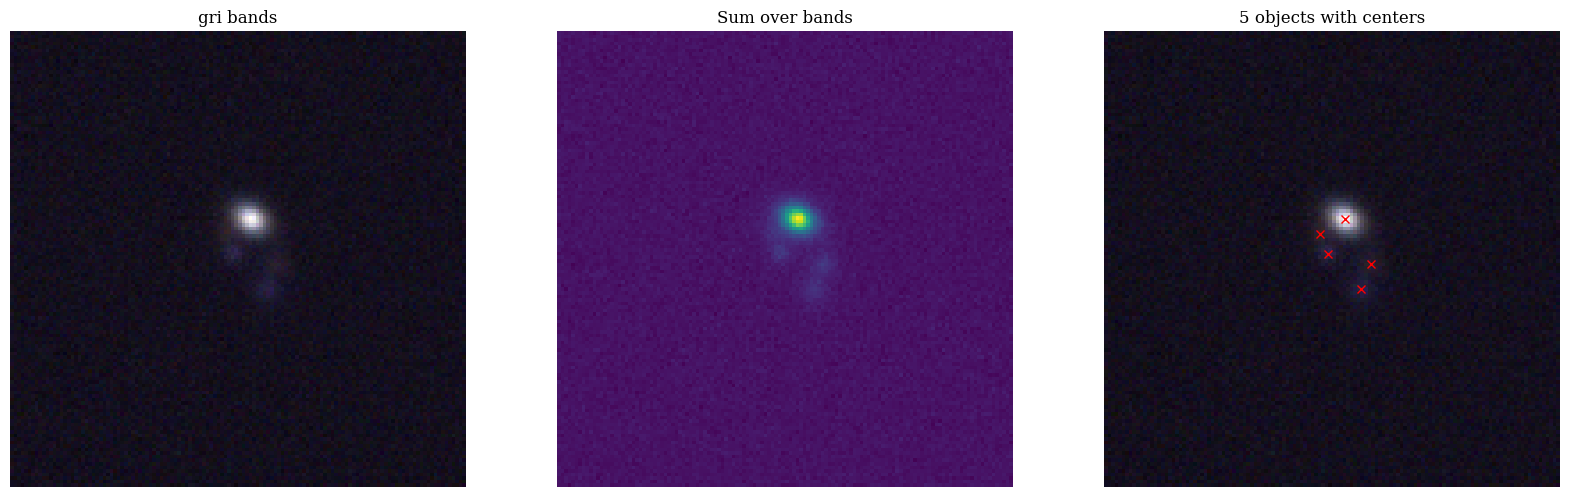

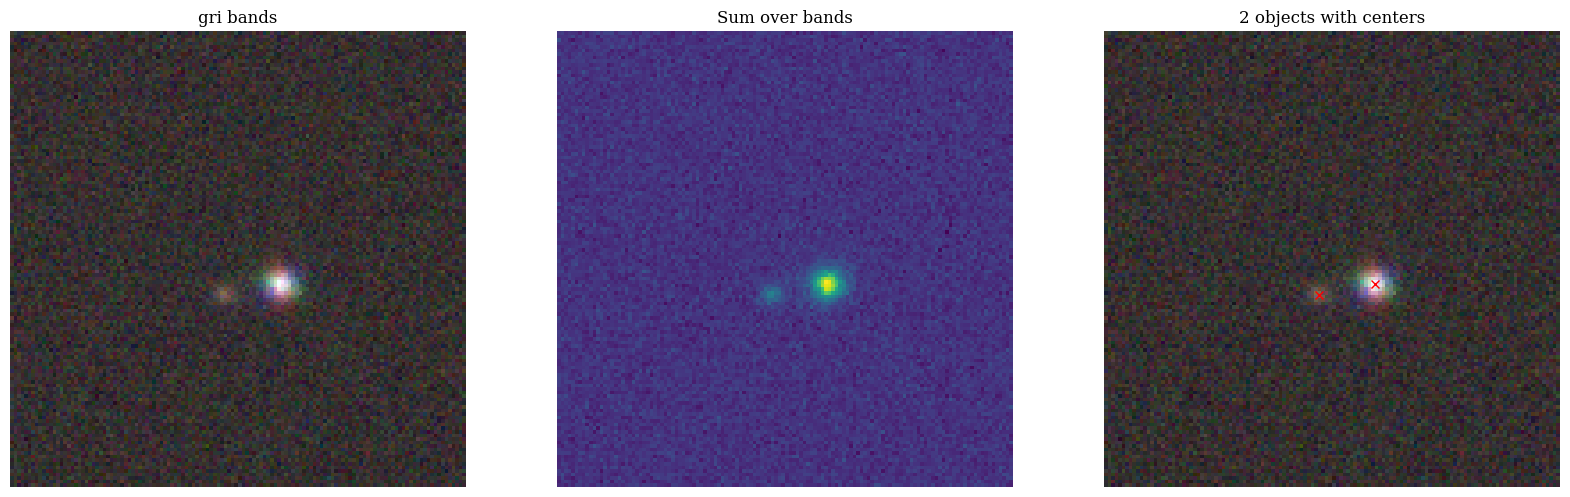

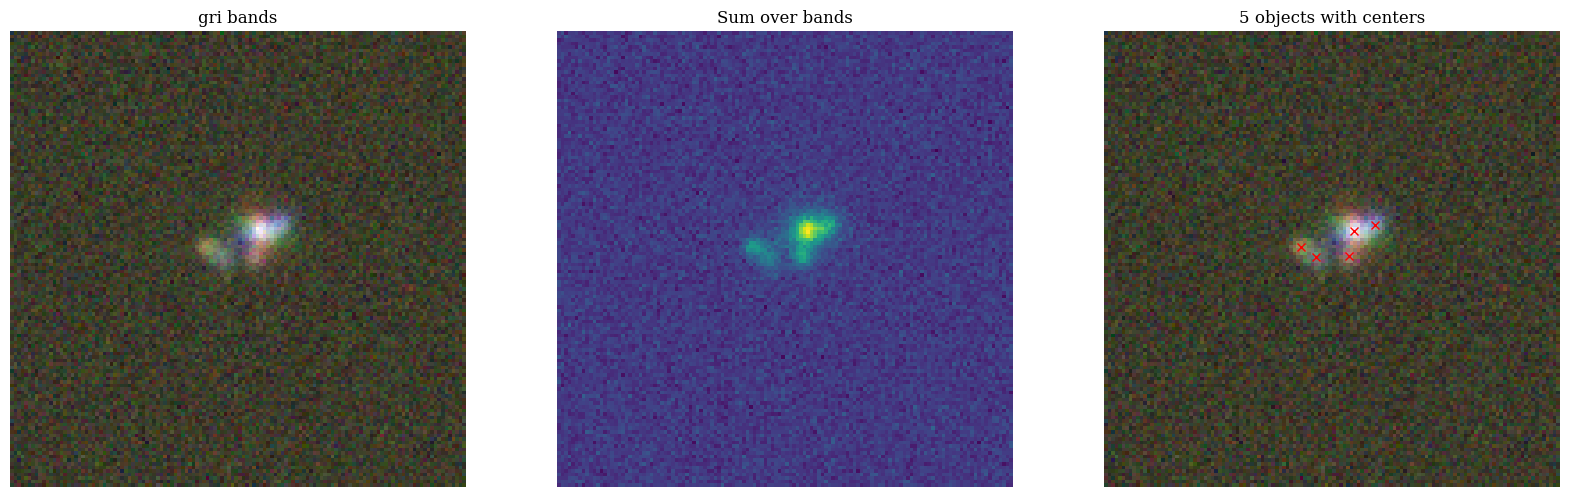

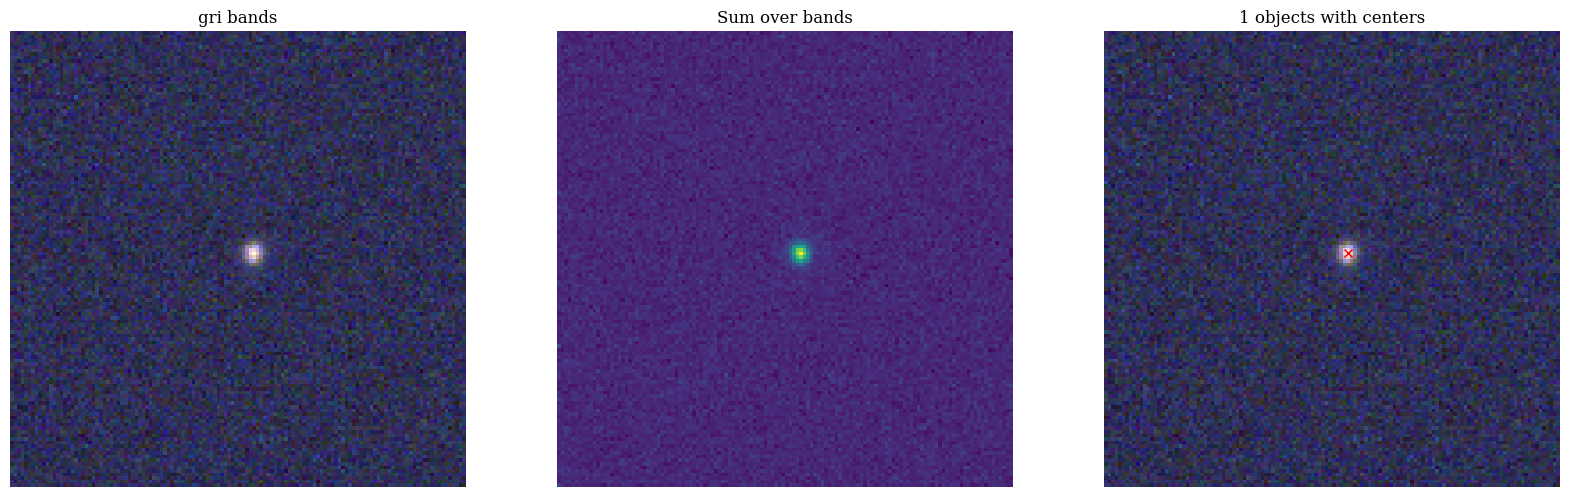

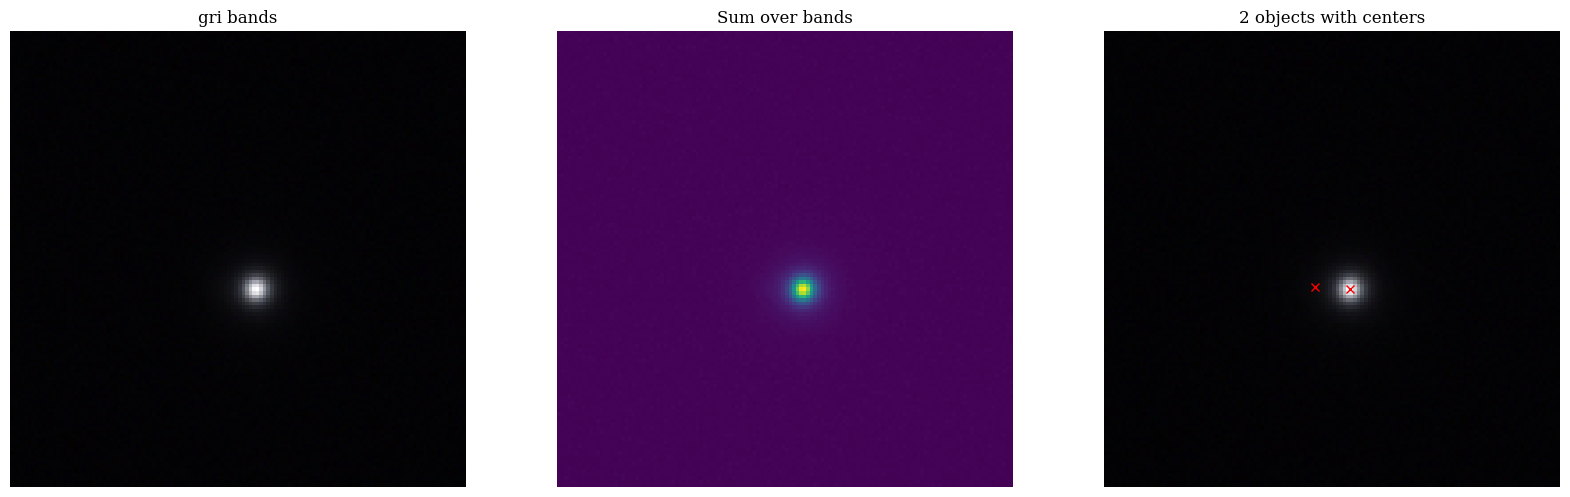

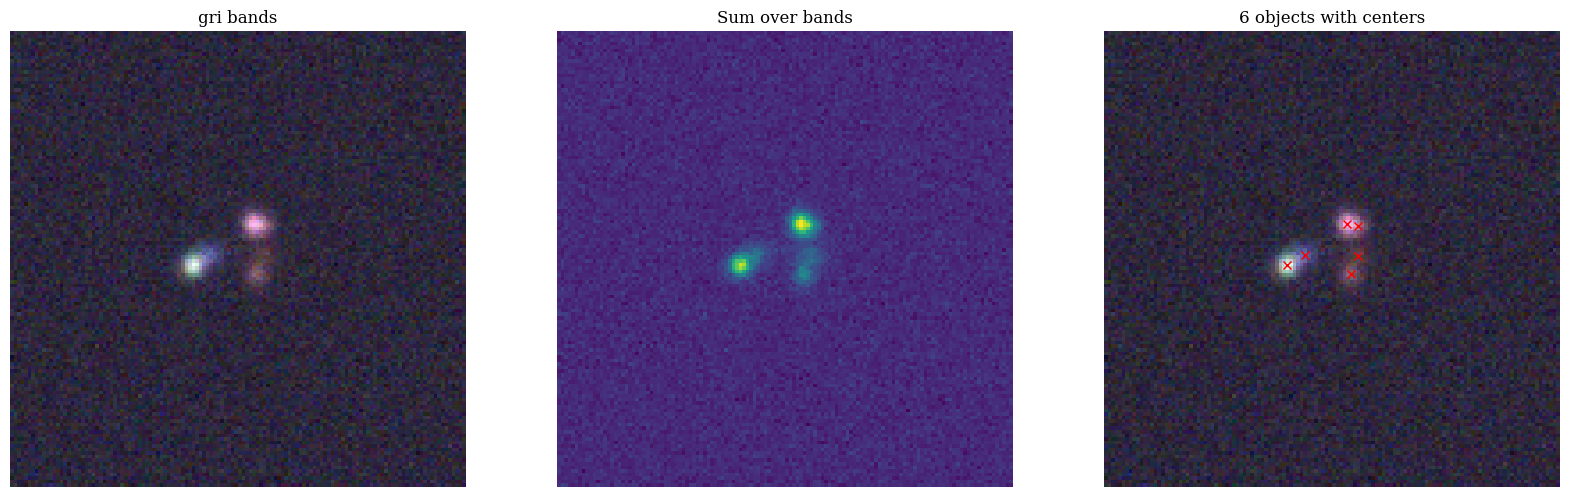

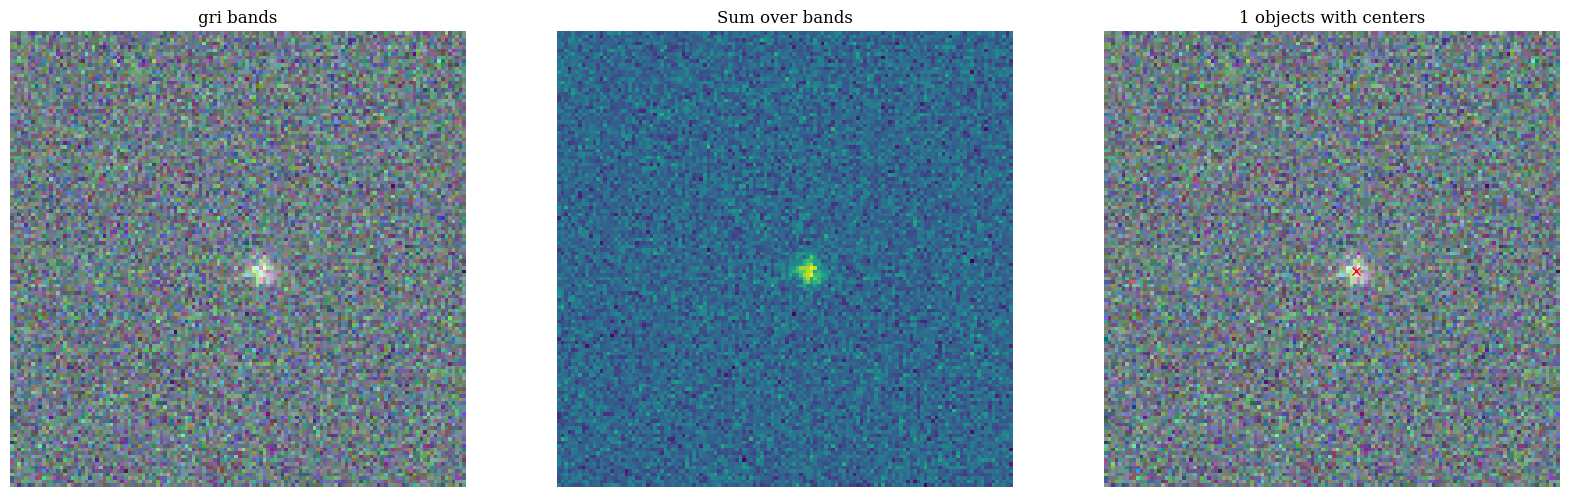

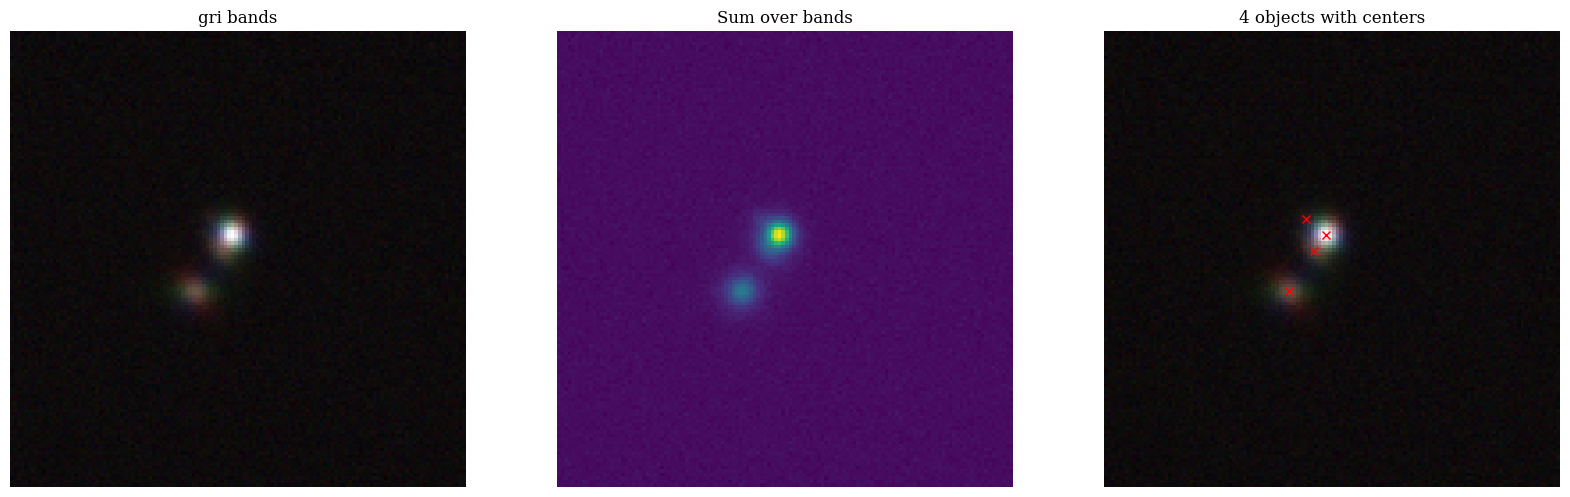

In [ ]:
# Define parameters
stamp_size = 25.6 #Original: 24
seed = 42
max_number = 6
max_shift = 5.0 # 10 had good results # Original: None

# Import the galaxy catalog
catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/btk_tutorial/data/OneDegSq.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

# Choose the sampling function
sampling_function = btk.sampling_functions.DefaultSampling(stamp_size=stamp_size,
                                                           max_number=max_number,
                                                           seed=seed)

# Load teh survey parameters
survey = btk.survey.get_surveys("LSST")

# Instantiate the image generator
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    [survey],
    stamp_size=stamp_size,
    batch_size=10, #,
    augment_data=True,
    seed=seed)

meas_generator = btk.measure.MeasureGenerator([btk.measure.sep_singleband_measure,btk.measure.basic_measure],
                                              draw_blend_generator)

metrics_generator = btk.metrics.MetricsGenerator(meas_generator,
                                                 target_meas={"ellipticity":btk.metrics.meas_ksb_ellipticity}, #See custom-tutorial for more details
                                                 meas_band_name="r")
blend_results, meas_results,results = next(metrics_generator)


# Create an example for when the basic peak finding fails
btk.plot_utils.plot_blends(blend_results['blend_images'][:],
                           blend_results['blend_list'][:])

# 1. Testing for red component testing with `BrightDefaultSampling`

`BrightDefaultSampling` is a mildly altered `DefaultSampling` function that allows for an user defined `mag_cut`

In [ ]:
class BrightDefaultSampling(btk.sampling_functions.SamplingFunction):
    """Default sampling function used for producing blend tables with an explicit mag cut."""

    def __init__(self, max_number=2, mag_cut=20, stamp_size=24.0, max_shift=None):
        """
        Args:
            max_number (int): Defined in parent class
            stamp_size (float): Size of the desired stamp.
            max_shift (float): Magnitude of maximum value of shift. If None then it
                             is set as one-tenth the stamp size. (in arcseconds)
            mag_cut (float): The maximum magnitude that the samples can go to.
        """
        super().__init__(max_number)
        self.stamp_size = stamp_size
        self.max_shift = max_shift if max_shift else self.stamp_size / 10.0
        self.mag_cut = mag_cut

    @property
    def compatible_catalogs(self):
        return "CatsimCatalog", "CosmosCatalog"

    def __call__(self, table):
        """Applies default sampling to the input CatSim-like catalog and returns an
        astropy table with entries corresponding to a blend centered close to postage
        stamp center.

        Function selects entries from input table that are brighter than 25.3 mag
        in the i band. Number of objects per blend is set at a random integer
        between 1 and Args.max_number. The blend table is then randomly sampled
        entries from the table after selection cuts. The centers are randomly
        distributed within 1/10th of the stamp size. Here even though the galaxies
        are sampled from a CatSim catalog, their spatial location are not
        representative of real blends.

        Args:
            table (astropy.table): Table containing entries corresponding to galaxies
                                   from which to sample.

        Returns:
            Astropy.table with entries corresponding to one blend.
        """
        number_of_objects = np.random.randint(1, self.max_number + 1)
        (q,) = np.where(table["ref_mag"] <= self.mag_cut)

        blend_table = table[np.random.choice(q, size=number_of_objects)]
        blend_table["ra"] = 0.0
        blend_table["dec"] = 0.0
        x_peak, y_peak = _get_random_center_shift(number_of_objects, self.max_shift)
        blend_table["ra"] += x_peak
        blend_table["dec"] += y_peak

        if np.any(blend_table["ra"] > self.stamp_size / 2.0) or np.any(
            blend_table["dec"] > self.stamp_size / 2.0
        ):
            warnings.warn("Object center lies outside the stamp")
        return blend_table
    

def _get_random_center_shift(num_objects, max_shift):
    """Returns random shifts in x and y coordinates between + and - max-shift in arcseconds.

    Args:
        num_objects (int): Number of x and y shifts to return.

    Returns:
        x_peak (float): random shift along the x axis
        y_peak (float): random shift along the x axis
    """
    x_peak = np.random.uniform(-max_shift, max_shift, size=num_objects)
    y_peak = np.random.uniform(-max_shift, max_shift, size=num_objects)
    return x_peak, y_peak

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

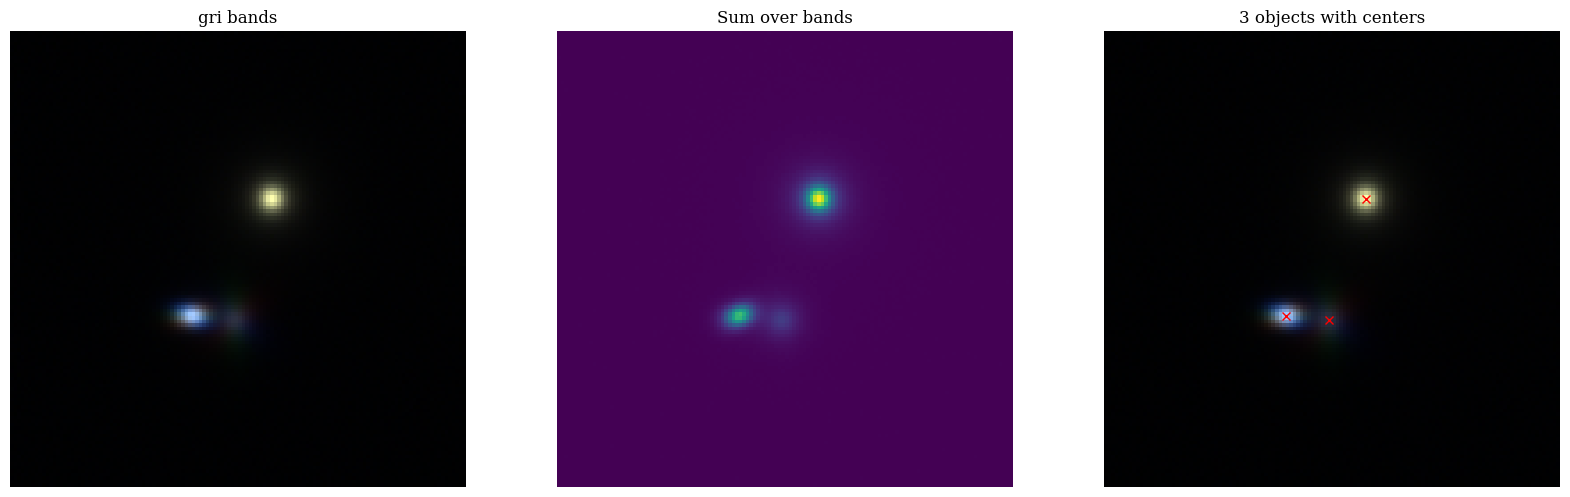

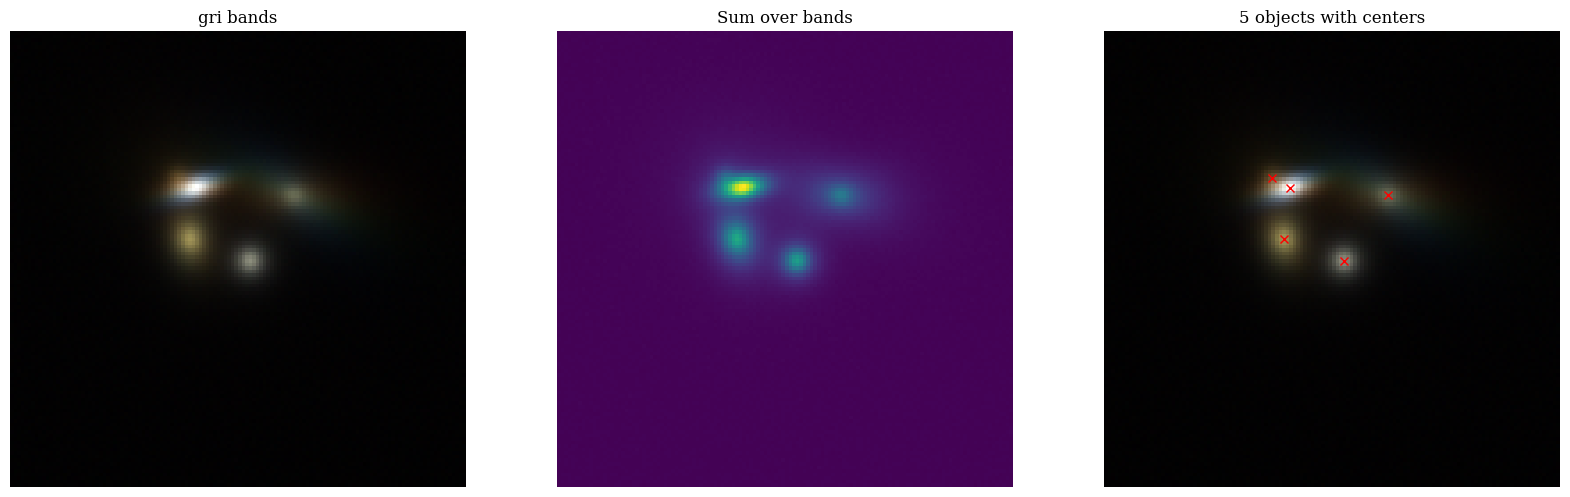

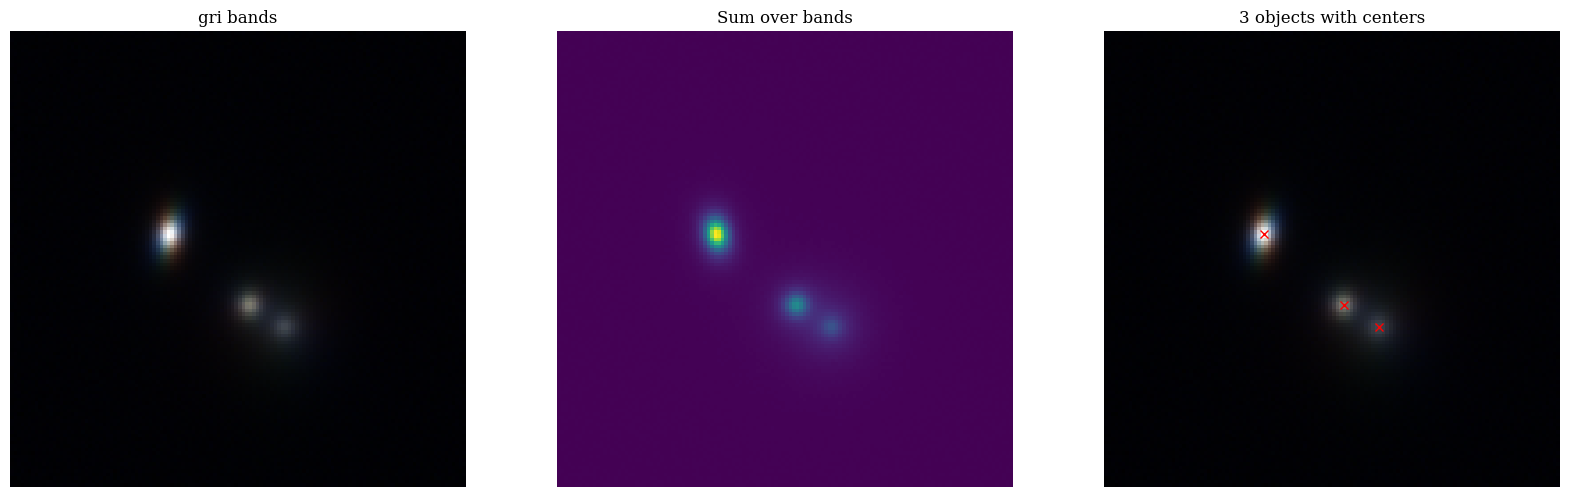

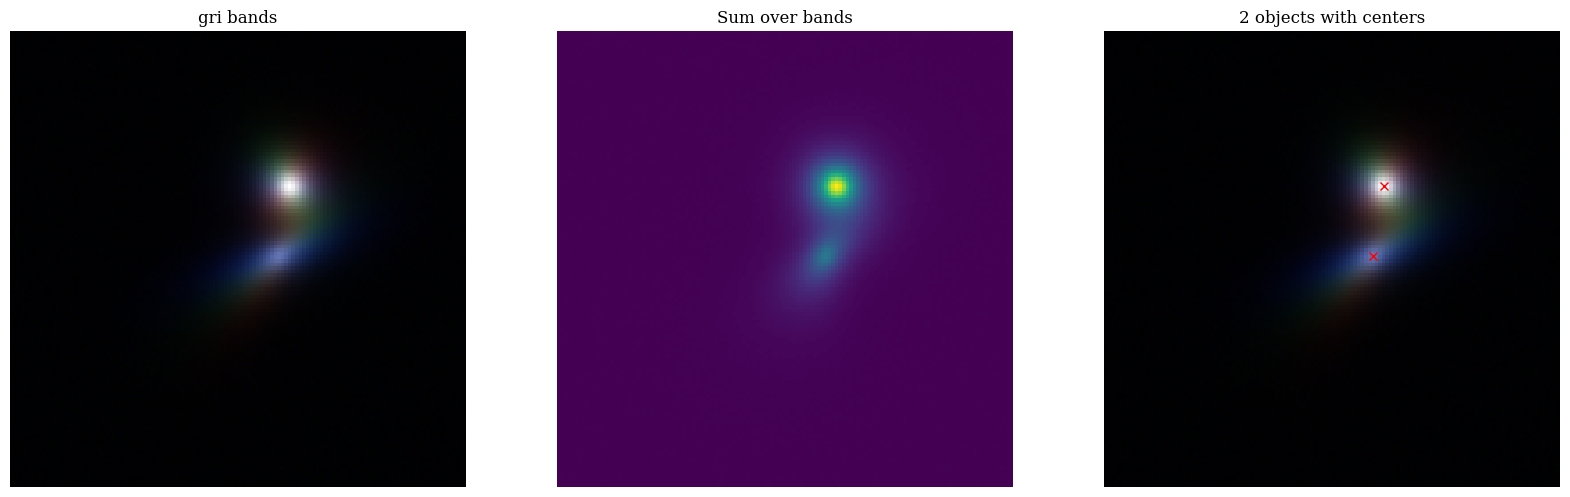

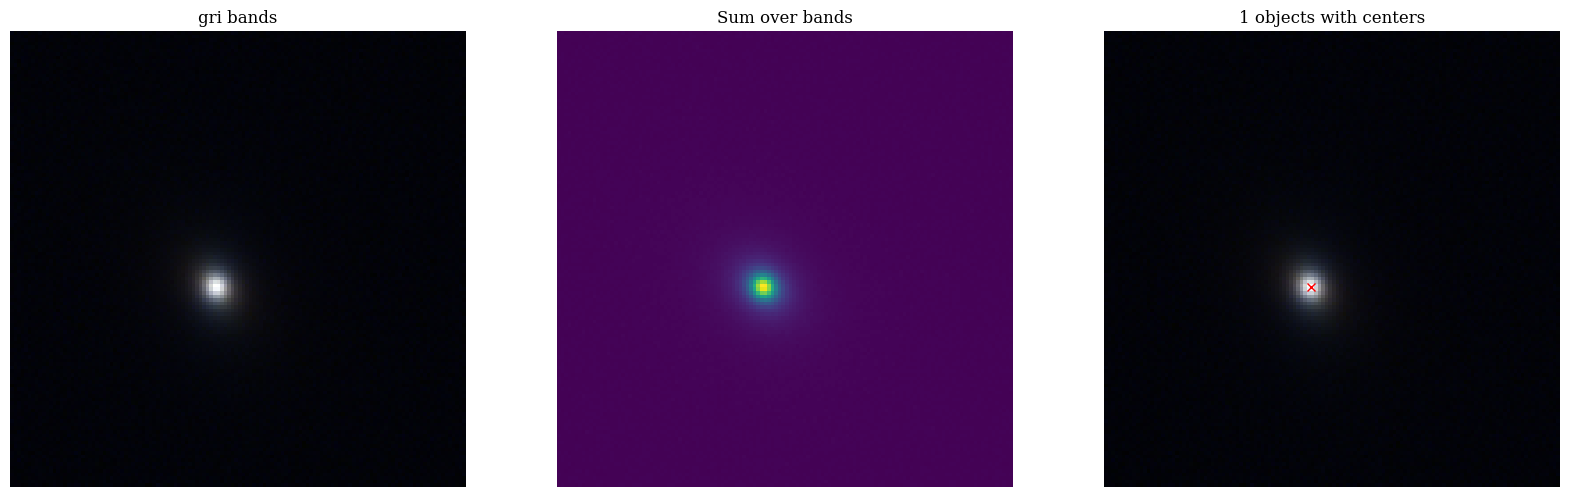

In [ ]:
# Define parameters
stamp_size = 25.6 #Original: 24
seed = 42
max_number = 6
max_shift = 5.0 # 10 had good results # Original: None

# Import the galaxy catalog
catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/btk_tutorial/data/OneDegSq.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

# Choose the sampling function
sampling_function = BrightDefaultSampling(stamp_size=stamp_size,
                                          mag_cut=20,
                                          max_number=max_number,
                                          max_shift=max_shift)
# Load teh survey parameters
survey = btk.survey.get_surveys("LSST")

# Instantiate the image generator
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    [survey],
    stamp_size=stamp_size,
    batch_size=10, #,
    augment_data=True,
    seed=seed)

meas_generator = btk.measure.MeasureGenerator([btk.measure.sep_singleband_measure,btk.measure.basic_measure],
                                              draw_blend_generator)

metrics_generator = btk.metrics.MetricsGenerator(meas_generator,
                                                 target_meas={"ellipticity":btk.metrics.meas_ksb_ellipticity}, #See custom-tutorial for more details
                                                 meas_band_name="r")
blend_results, meas_results,results = next(metrics_generator)

# Create an example for when the basic peak finding fails
btk.plot_utils.plot_blends(blend_results['blend_images'][:5],
                           blend_results['blend_list'][:5])


# 2. Now testing for red component with `PairSampling`  

`PairSampling` is a modified version of `BrightDefaultSampling` with a `mag_cut` from before but forcing the sampler to only output bright pairs of galaxies that are always a set distance apart.

In [ ]:
class PairSampling(btk.sampling_functions.SamplingFunction):
    """
    Sampling function that generates two galaxies where one is centered 
    and the other one is shifted. Every generated sample will have the 
    shifted galaxy the same distance away from the centered galaxy.
    """
    
    def __init__(self, stamp_size=24.0, max_shift=None, mag_cut=20):
        super().__init__(2)
        self.stamp_size = stamp_size
        self.max_shift = max_shift if max_shift else self.stamp_size / 10.0
        self.mag_cut = mag_cut

    @property
    def compatible_catalogs(self):
        return "CatsimCatalog", "CosmosCatalog"

    def __call__(self,table):
        (q_bright,) = np.where(table["ref_mag"] <= self.mag_cut)
        
        indexes = [np.random.choice(q_bright),np.random.choice(q_bright)]
        blend_table = table[indexes]
        
        blend_table["ra"] = 0.0
        blend_table["dec"] = 0.0
        
        x_peak, y_peak = _get_set_center_shift(self.max_shift)
        
        blend_table["ra"][1] += x_peak
        blend_table["dec"][1] += y_peak

        if np.any(blend_table["ra"] > self.stamp_size / 2.0) or np.any(
            blend_table["dec"] > self.stamp_size / 2.0
        ):
            warnings.warn("Object center lies outside the stamp")
        return blend_table


def _get_set_center_shift(max_shift):
    """
    Returns the shift for the off-centered galaxy. Every sample will
    have the same distance between the centered galaxy and shifted galaxy.
    The function returns the shifts in x and y coordinates at +/- max-shift 
    in arcseconds.
    
    Args:
        max_shift (int): Size of the max_shift

    Returns:
        x_peak (float): shift along the x axis
        y_peak (float): shift along the x axis
    """
    dist = np.asarray([-max_shift, max_shift])
    x_indices = np.random.choice(len(dist), size=1, p=None)
    y_indices = np.random.choice(len(dist), size=1, p=None)
    x_peak = dist[x_indices]
    y_peak = dist[y_indices]
    return x_peak, y_peak 

In [ ]:
# Define parameters
stamp_size = 25.6 #Original: 24
seed = 42
max_number = 2
max_shift = 5.0 # 10 had good results # Original: None

# Import the galaxy catalog
catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/btk_tutorial/data/OneDegSq.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

# Choose the sampling function
sampling_function = PairSampling(stamp_size=stamp_size,
                                 mag_cut=20,
                                 max_shift=max_shift)
# Load teh survey parameters
survey = btk.survey.get_surveys("LSST")

# Instantiate the image generator
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    [survey],
    stamp_size=stamp_size,
    batch_size=10, #,
    augment_data=True,
    seed=seed)

meas_generator = btk.measure.MeasureGenerator([btk.measure.sep_singleband_measure,btk.measure.basic_measure],
                                              draw_blend_generator)

metrics_generator = btk.metrics.MetricsGenerator(meas_generator,
                                                 target_meas={"ellipticity":btk.metrics.meas_ksb_ellipticity}, #See custom-tutorial for more details
                                                 meas_band_name="r")
blend_results, meas_results,results_pair = next(metrics_generator)

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

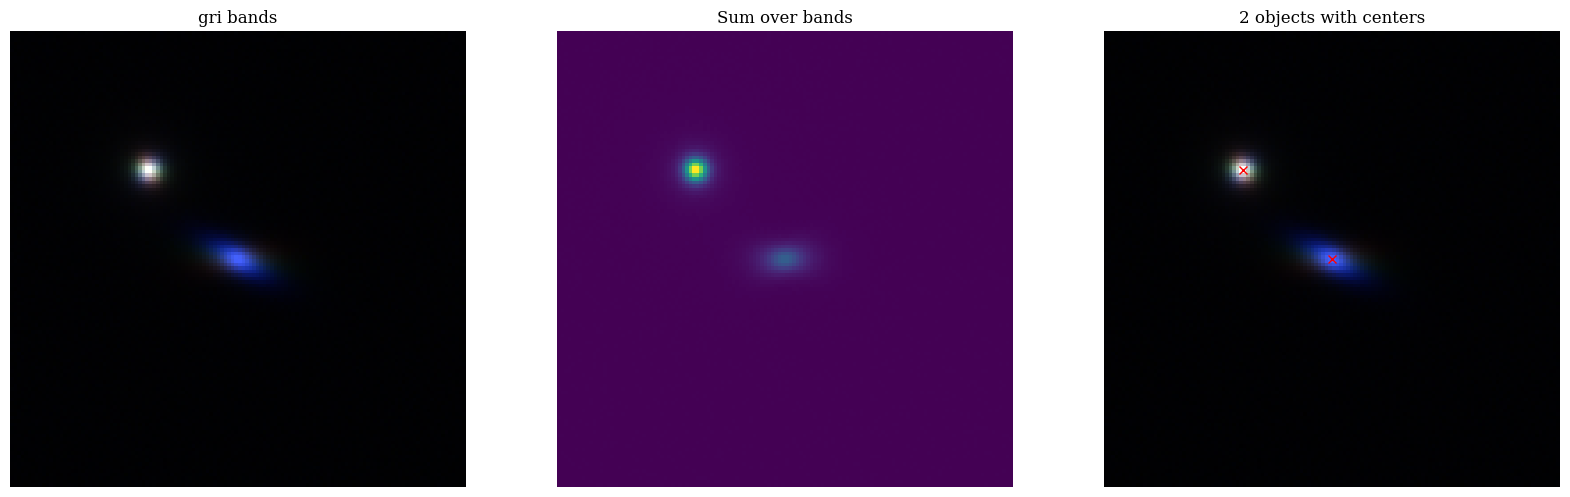

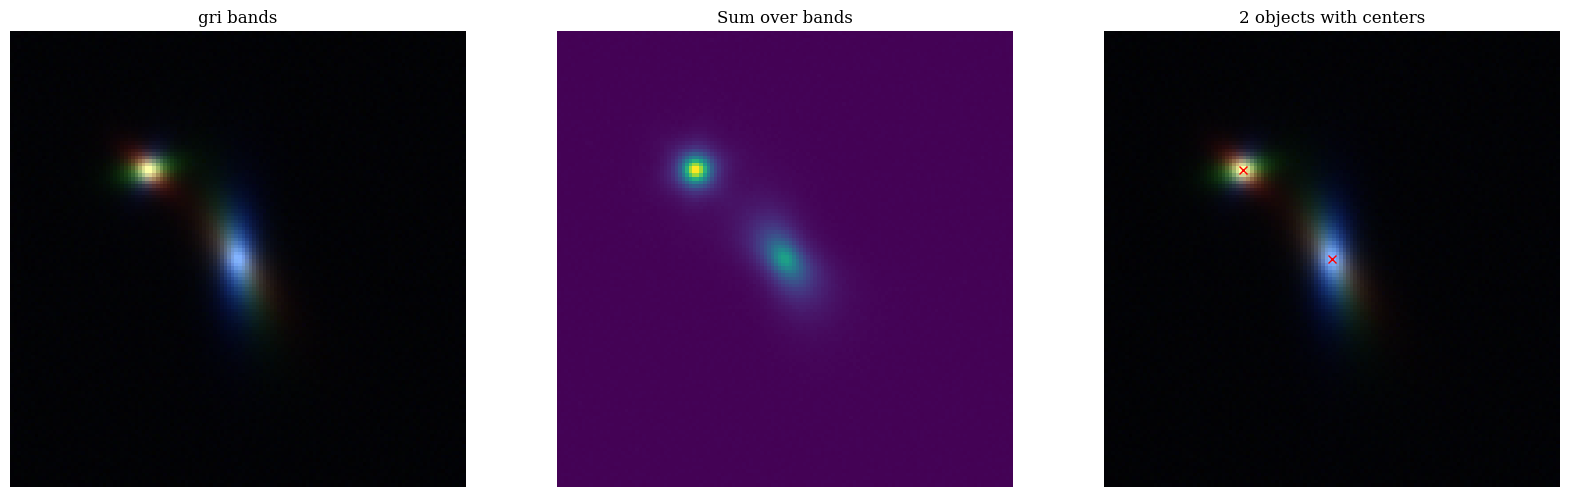

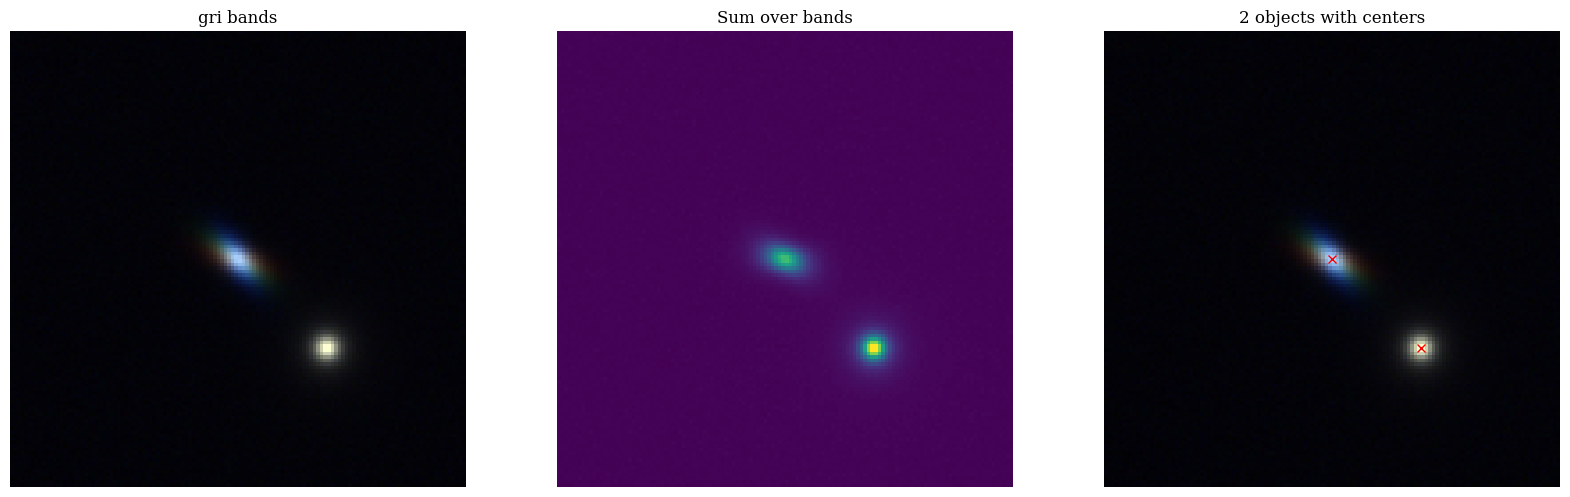

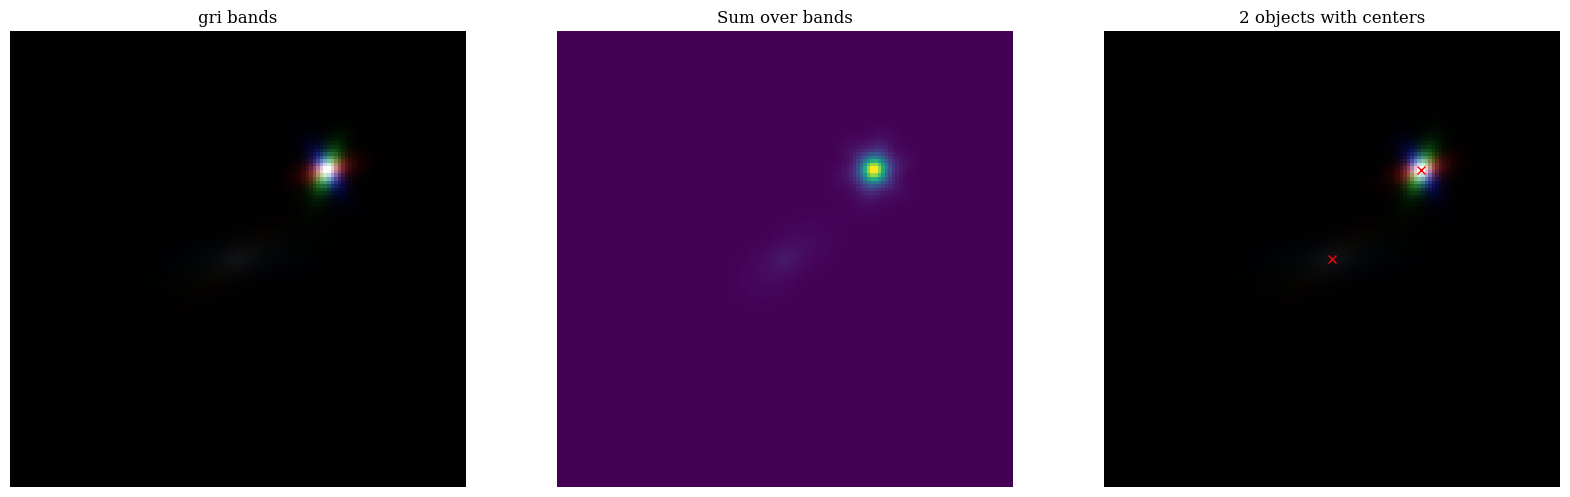

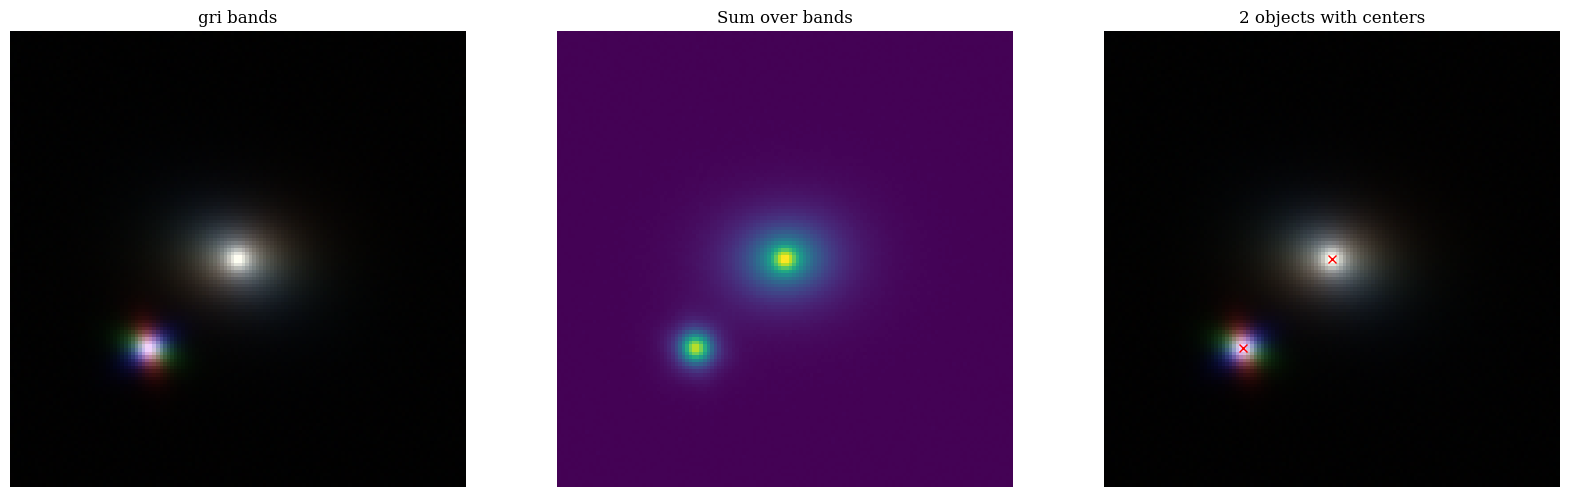

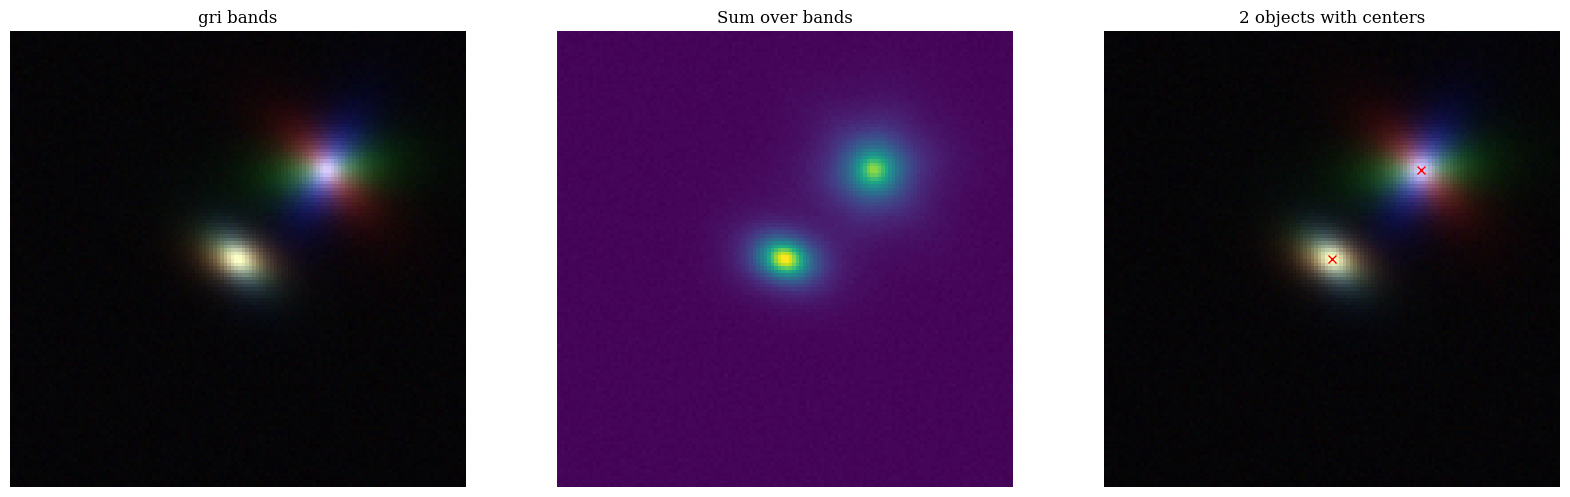

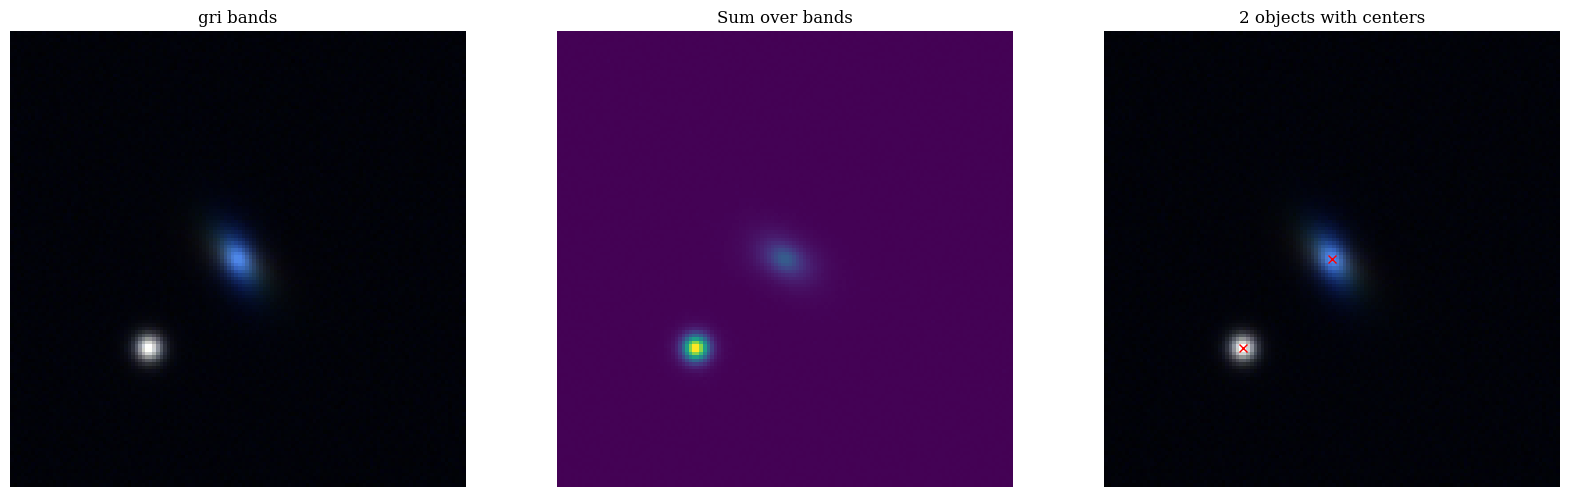

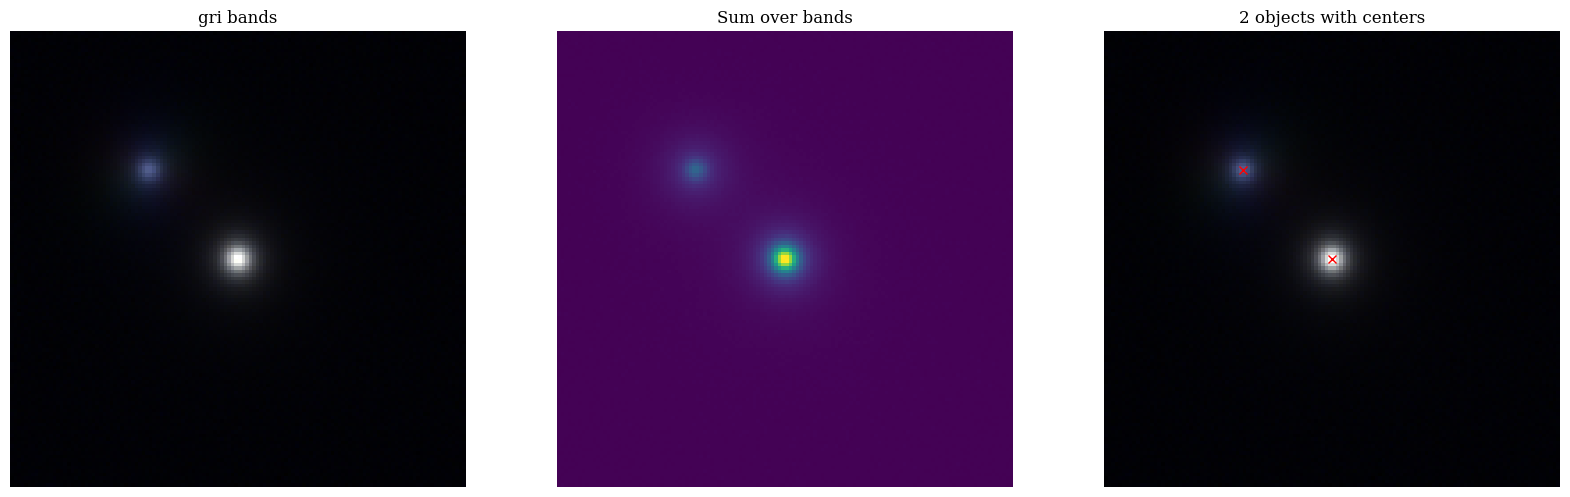

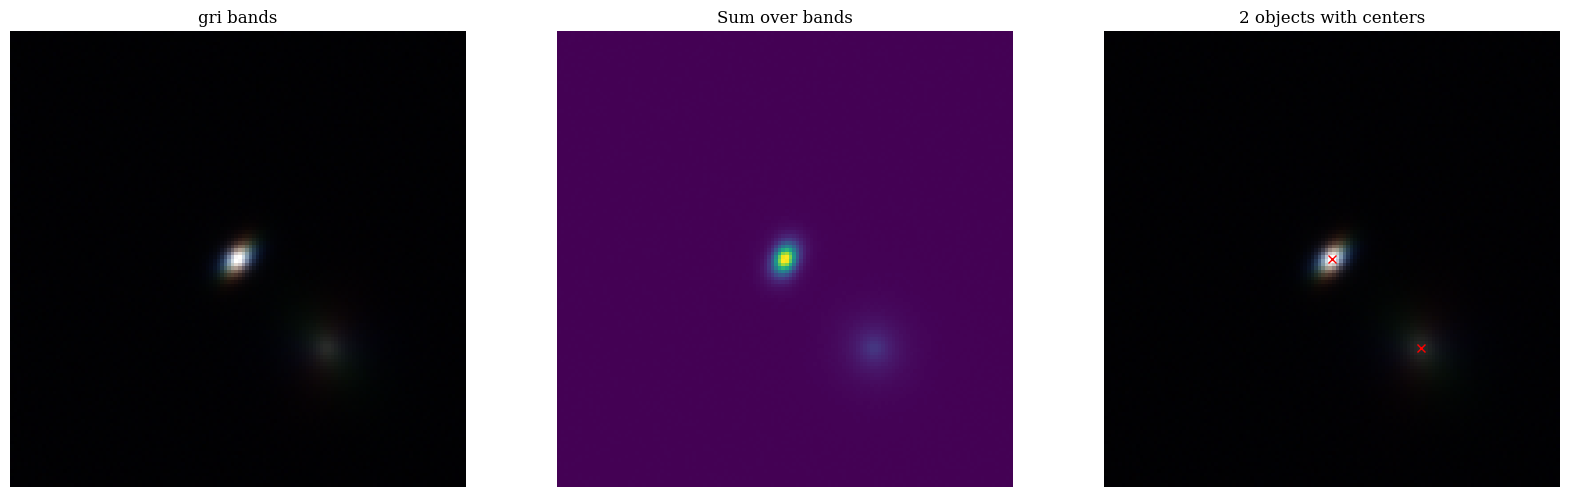

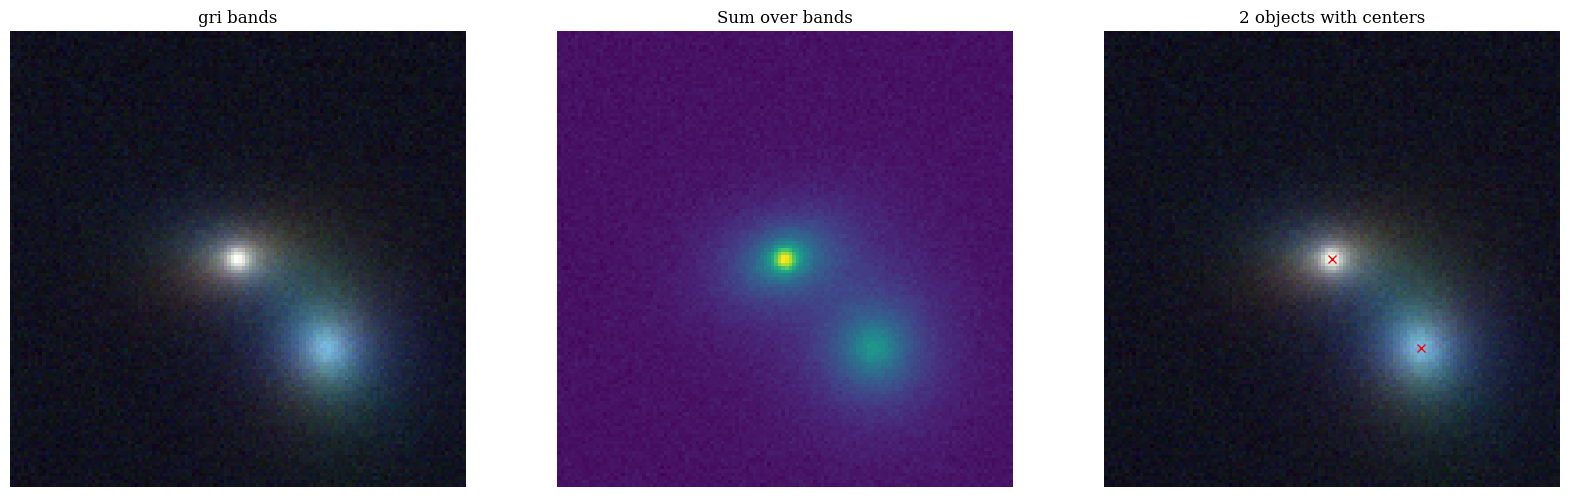

In [ ]:
# Create an example for when the basic peak finding fails
btk.plot_utils.plot_blends(blend_results['blend_images'][:],
                           blend_results['blend_list'][:])